## Importing need packages

In [1]:
import pandas as pd
import urllib.request
import pymatgen
from pymatgen.ext.matproj import MPRester
import json
import numpy as np
import matplotlib.pyplot as plt
import statistics
from tqdm import tqdm
import threading
import time
import csv

## Fuction to check API health as the API get over loaded when asking for samples from each library and can give a 403 error.

In [2]:
def HTEM_API_Check():
    HTEM_url = 'https://htem-api.nrel.gov/check'
    try:
        HTEM_response = urllib.request.urlopen(HTEM_url)
    except urllib.error.HTTPError:
        return False
    except urllib.error.URLError:
        return False
    HTEM_response = urllib.request.urlopen(HTEM_url)
    HTEM_response = json.loads(HTEM_response.read())
    if HTEM_response['status'] == 'ok':
        return True

## Get all libraries that have optical data as the band gap data in HTEM is calcualted from the Tauc plot of the optical data, so only this subset can contain optical band gap values.

In [3]:
elt_url = 'https://htem-api.nrel.gov/api/sample_library?element='
while HTEM_API_Check() == False:
        time.sleep(30)
response = urllib.request.urlopen(elt_url)
data = json.loads(response.read())
HTEM_All_Comps = []
HTEM_All_ids = []
for entry in data:
    if entry['has_opt'] > 0:
        HTEM_All_Comps.append(entry['elements'])
        HTEM_All_ids.append(entry['id'])

## Get optical band gaps for samples, binned by library, and collect the mean, stddev, and composition space of each library. (Note, this takes a while as it requires looping 600+ libraries with 40+ samples per library. Although, by using threads it runs in much less time, however the API gets overloaded by the muliptle threads so the serial method was used)

In [4]:
HTEM_BGData = []

def HTEM_getBGInfo_perlib(lib):
    while HTEM_API_Check() == False:
        time.sleep(30)
    lib_url = 'https://htem-api.nrel.gov/api/sample_library/'+str(lib)
    lib_response = urllib.request.urlopen(lib_url)
    lib_data = json.loads(lib_response.read())
    lib_BG = []
    lib_samp_ids = lib_data['sample_ids']
    for samp_id in lib_samp_ids:
        samp_url = 'https://htem-api.nrel.gov/api/sample/'+str(samp_id)
        while HTEM_API_Check() == False:
            time.sleep(30)
        samp_response = urllib.request.urlopen(samp_url)
        samp_data = json.loads(samp_response.read())
        try:
            ToReturn = samp_data['opt_direct_bandgap']
        except KeyError:
            break
        if ToReturn != None:
            lib_BG.append(float(ToReturn))
    if len(lib_BG) > 0:
        HTEM_BGMean = statistics.mean(lib_BG)
        HTEM_BGStdDev = statistics.pstdev(lib_BG)
        HTEM_WithBG = lib_data['elements']
        el_sys = ''
        for i in HTEM_WithBG:
            if i != HTEM_WithBG[-1]:
                el_sys = el_sys+str(i)+'-'
            else:
                el_sys = el_sys+str(i)
        HTEM_BGData.append([el_sys,HTEM_BGMean,HTEM_BGStdDev])
    return

In [5]:
for i in tqdm(range(0,601,1)):
    while HTEM_API_Check() == False:
        time.sleep(120)
    HTEM_getBGInfo_perlib(HTEM_All_ids[i])

100%|██████████| 373/373 [4:44:11<00:00, 47.30s/it]  


#### Export as a CSV so that it can be reloaded later

In [8]:
myFile = open('HTEM_BG_Results.csv', 'w')  
with myFile:  
    writer = csv.writer(myFile)
    writer.writerows(HTEM_BGData)

#### Import results from CSV storage 

In [67]:
DataPath_BG = '/Users/ktalley/Data Incubator/Proposal/Data Storage/HTEM_BG_Results.csv'
with open(DataPath_BG,'r') as CSVFileIn:
    reader = csv.reader(CSVFileIn)
    HTEM_BGData_In = list(reader)
HTEM_BGData = []
for lib in HTEM_BGData_In:
    lib_Mean = lib[1]
    lib_StdDev = lib[2]
    lib_sys = lib[0]
    if len(lib_sys) > 1:
        lib_sys_list = lib_sys.split('-')
        lib_sys_list = sorted(lib_sys_list)
        el_sys = ''
        for i in lib_sys_list:
            if i != lib_sys_list[-1]:
                el_sys = el_sys+str(i)+'-'
            else:
                el_sys = el_sys+str(i)
    HTEM_BGData.append([el_sys,lib_Mean,lib_StdDev])

## Get unique systems from the results, then collect non-zero bandgap values from the materials project

In [68]:
HTEM_BG_Sys = sorted(list(set([lib[0] for lib in HTEM_BGData])))

## Loop through all HTEM results and bin by system.

In [105]:
HTEM_BGData_BGs = []
for sys in HTEM_BG_Sys:
    sys_BGs = []
    sys_BGs_devs = []
    for lib in HTEM_BGData:
        lib_sys = lib[0]
        if lib_sys == sys:
            sys_BGs.append(float(lib[1]))
            sys_BGs_devs.append(float(lib[2]))
    HTEM_BGData_BGs.append([sys,sys_BGs,sys_BGs_devs])

## Get BG values for all strucutres in each system from the Materials Project

In [106]:
def MatPro_BG_by_sys(sys):
    mpr = MPRester("HZC8lZqpZHrTqGa5f") 
    MP_BG = mpr.get_data(sys, prop="band_gap")
    MP_All_BG = []
    MP_Included = 0
    for entry in MP_BG:
        This_BG = entry['band_gap']
        if This_BG > 0:
            MP_All_BG.append(This_BG)
            MP_Included +=1
    if MP_Included > 0:
        return [sys,MP_All_BG,MP_Included]
    else:
        return None

In [84]:
MP_BGData = []
Sys_BothBG = []
for sys in tqdm(HTEM_BG_Sys):
    MP_result = MatPro_BG_by_sys(sys)
    if MP_result != None:
        MP_BGData.append(MP_result)
        Sys_BothBG.append(sys)

100%|██████████| 80/80 [00:26<00:00,  4.18it/s]


## loop through systems contatined in both and find the MP strucutre that is closest in value. Make BG and StdDev list for plotting

In [158]:
HTEM_sys_only = [row[0] for row in HTEM_BGData_BGs]

Plotting_HTEM_BG_2 = []
Plotting_HTEM_StdDev_2 = []
Plotting_MP_BG_2 = []
Plotting_MP_StdDev_2 = []
Plotting_Sys_2 = []

Plotting_HTEM_BG_3 = []
Plotting_HTEM_StdDev_3 = []
Plotting_MP_BG_3 = []
Plotting_MP_StdDev_3 = []
Plotting_Sys_3 = []

Plotting_HTEM_BG_4 = []
Plotting_HTEM_StdDev_4 = []
Plotting_MP_BG_4 = []
Plotting_MP_StdDev_4 = []
Plotting_Sys_4 = []

Plotting_HTEM_BG_All = []
Plotting_HTEM_StdDev_All = []
Plotting_MP_BG_All = []
Plotting_MP_StdDev_All = []
Plotting_Sys_All = []

for sys in Sys_BothBG:
    index_HTEM = HTEM_sys_only.index(sys)
    index_MP = Sys_BothBG.index(sys)
    
    HTEM_TheseBG = HTEM_BGData_BGs[index_HTEM][1]
    HTEM_MeanBG = statistics.mean(HTEM_TheseBG)
    
    HTEM_TheseStdDev = HTEM_BGData_BGs[index_HTEM][2]
    HTEM_MeanBGStdDev = statistics.mean(HTEM_TheseStdDev)
    
    MP_TheseBG = MP_BGData[index_MP][1]
    MP_BGDev =  statistics.pstdev(HTEM_TheseStdDev)

    MP_MinDiff = 10
    
    for BG in MP_TheseBG: #look for closest in value
        if abs(BG-HTEM_MeanBG) < MP_MinDiff:
            MP_MinDiff = abs(BG-HTEM_MeanBG)
            MP_ClosestBG = BG
    sys_components = len(sys.split("-"))        
    if sys_components == 2:
        Plotting_HTEM_BG_2.append(HTEM_MeanBG)
        Plotting_HTEM_StdDev_2.append(HTEM_MeanBGStdDev)
        Plotting_MP_BG_2.append(MP_ClosestBG)
        Plotting_MP_StdDev_2.append(MP_BGDev)
        Plotting_Sys_2.append(sys)
    elif sys_components == 3:
        Plotting_HTEM_BG_3.append(HTEM_MeanBG)
        Plotting_HTEM_StdDev_3.append(HTEM_MeanBGStdDev)
        Plotting_MP_BG_3.append(MP_ClosestBG)
        Plotting_MP_StdDev_3.append(MP_BGDev)
        Plotting_Sys_3.append(sys)
    elif sys_components == 4:
        Plotting_HTEM_BG_4.append(HTEM_MeanBG)
        Plotting_HTEM_StdDev_4.append(HTEM_MeanBGStdDev)
        Plotting_MP_BG_4.append(MP_ClosestBG)
        Plotting_MP_StdDev_4.append(MP_BGDev)
        Plotting_Sys_4.append(sys)
    Plotting_HTEM_BG_All.append(HTEM_MeanBG)
    Plotting_HTEM_StdDev_All.append(HTEM_MeanBGStdDev)
    Plotting_MP_BG_All.append(MP_ClosestBG)
    Plotting_MP_StdDev_All.append(MP_BGDev)
    Plotting_Sys_All.append(sys)

## Make plot to show comparison for each system

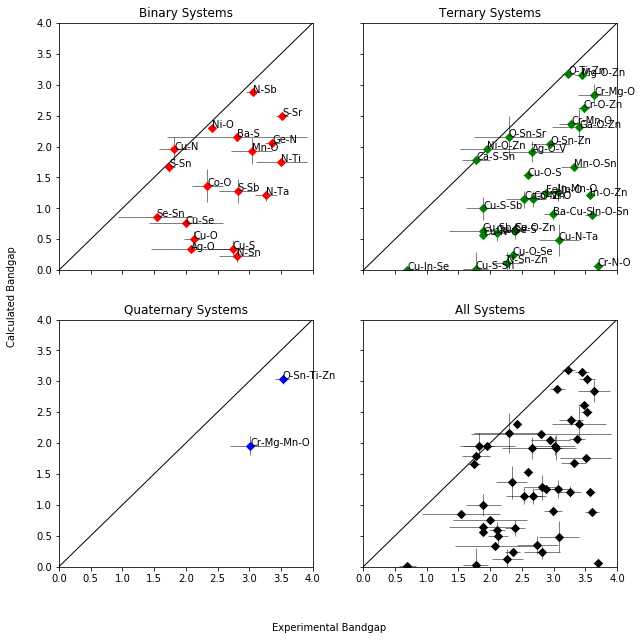

In [182]:
f, ((p2,p3),(p4,pAll)) = plt.subplots(2,2, sharex=True, sharey=True)

f.text(0.5, 0.04, 'Experimental Bandgap', ha='center', va='center')
f.text(0.06, 0.5, 'Calculated Bandgap', ha='center', va='center', rotation='vertical')

#plt.xlabel('Experimental Bandgap')
#plt.ylabel('Calculated Bandgap')
plt.xlim((0, 4))
plt.ylim((0, 4))

plt.rcParams["figure.figsize"] = (10,10)
p2.errorbar(Plotting_HTEM_BG_2, 
             Plotting_MP_BG_2, 
             xerr=Plotting_HTEM_StdDev_2, 
             yerr=Plotting_MP_StdDev_2,  
             fmt='D', 
             color='red',
             ecolor='black',
             elinewidth=.5)
p2.plot([0, 4], [0, 4], 'k-', lw=1)
for i in range(len(Plotting_Sys_2)):
    p2.annotate(Plotting_Sys_2[i], (Plotting_HTEM_BG_2[i], Plotting_MP_BG_2[i]))
p2.set_title('Binary Systems')

p3.errorbar(Plotting_HTEM_BG_3, 
             Plotting_MP_BG_3, 
             xerr=Plotting_HTEM_StdDev_3, 
             yerr=Plotting_MP_StdDev_3,  
             fmt='D', 
             color='green',
             ecolor='black',
             elinewidth=.5)
p3.plot([0, 4], [0, 4], 'k-', lw=1)
for i in range(len(Plotting_Sys_3)):
    p3.annotate(Plotting_Sys_3[i], (Plotting_HTEM_BG_3[i], Plotting_MP_BG_3[i]))
p3.set_title('Ternary Systems')
    
p4.errorbar(Plotting_HTEM_BG_4, 
             Plotting_MP_BG_4, 
             xerr=Plotting_HTEM_StdDev_4, 
             yerr=Plotting_MP_StdDev_4,  
             fmt='D', 
             color='blue',
             ecolor='black',
             elinewidth=.5)
p4.plot([0, 4], [0, 4], 'k-', lw=1)
for i in range(len(Plotting_Sys_4)):
    p4.annotate(Plotting_Sys_4[i], (Plotting_HTEM_BG_4[i], Plotting_MP_BG_4[i]))
p4.set_title('Quaternary Systems')

pAll.errorbar(Plotting_HTEM_BG_All, 
             Plotting_MP_BG_All, 
             xerr=Plotting_HTEM_StdDev_All, 
             yerr=Plotting_MP_StdDev_All,  
             fmt='D', 
             color='black',
             ecolor='black',
             elinewidth=.5)
pAll.plot([0, 4], [0, 4], 'k-', lw=1)
pAll.set_title('All Systems')

plt.show()